# Pratical excersice 1: Chest and breast classification

Before you start to solve the exercise, please write your TUM-IDs alongside the names of all group members. This will enable us to assign grades accurately. Thank you.

Member 1:

Member 2:

Member 3:

...

In [ ]:
!pip install medmnist

In [1]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score
from matplotlib import pyplot as plt

import medmnist
from medmnist import INFO

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available. Training on GPU.")
else:
    device = torch.device("cpu")
    print("CUDA is not available. Training on CPU.")

CUDA is available. Training on GPU.


## Task 1: 2D breast ultrasound classification.

## Dataloading
We first load a 2D dataset breast ultrasound dataset-BreastMNIST, preprocess it and encapsulate it into dataloader form. Please fill the empty blanks in the following bloacks. You are expected to show the details of training, validation, and test dataset.

In [2]:
data_flag_2d = 'breastmnist' # here the name of dataset should be passed.
download = True

info = INFO[data_flag_2d] # INFO is embedded in the medmnist containing basic information of datasets
print(info)
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

{'python_class': 'BreastMNIST', 'description': 'The BreastMNIST is based on a dataset of 780 breast ultrasound images. It is categorized into 3 classes: normal, benign, and malignant. As we use low-resolution images, we simplify the task into binary classification by combining normal and benign as positive and classifying them against malignant as negative. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images of 1×500×500 are resized into 1×28×28.', 'url': 'https://zenodo.org/record/6496656/files/breastmnist.npz?download=1', 'MD5': '750601b1f35ba3300ea97c75c52ff8f6', 'task': 'binary-class', 'label': {'0': 'malignant', '1': 'normal, benign'}, 'n_channels': 1, 'n_samples': {'train': 546, 'val': 78, 'test': 156}, 'license': 'CC BY 4.0'}


In [3]:
"""
Here goes with the hyperparameters for your model.
"""
# hyparameters
BATCH_SIZE = 128
EPOCH_NUM = 100
lr = 0.001

In [4]:
"""
Please generate datasets and dataloaders for training, validation, and test dataset.
Datasets should be an object of DataClass and dataloaders should be an object of torch.utils.data.DataLoader.
"""

# preprocessing such as conversion to tensor and normalization
data_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# get the data class
train_dataset = DataClass(split="train", transform=data_transforms, download=download)
test_dataset = DataClass(split="test", transform=data_transforms, download=download)
val_dataset = DataClass(split="val", transform=data_transforms, download=download)

# encapsulate datasets into Dataloader form
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
val_loader = DataLoader(dataset=val_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

Using downloaded and verified file: /home/viet/.medmnist/breastmnist.npz
Using downloaded and verified file: /home/viet/.medmnist/breastmnist.npz
Using downloaded and verified file: /home/viet/.medmnist/breastmnist.npz


Dataset BreastMNIST (breastmnist)
    Number of datapoints: 546
    Root location: /home/viet/.medmnist
    Split: train
    Task: binary-class
    Number of channels: 1
    Meaning of labels: {'0': 'malignant', '1': 'normal, benign'}
    Number of samples: {'train': 546, 'val': 78, 'test': 156}
    Description: The BreastMNIST is based on a dataset of 780 breast ultrasound images. It is categorized into 3 classes: normal, benign, and malignant. As we use low-resolution images, we simplify the task into binary classification by combining normal and benign as positive and classifying them against malignant as negative. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images of 1×500×500 are resized into 1×28×28.
    License: CC BY 4.0
Dataset BreastMNIST (breastmnist)
    Number of datapoints: 78
    Root location: /home/viet/.medmnist
    Split: val
    Task: binary-class
    Number of channels: 1
    Meaning of labels: {'0': 'maligna

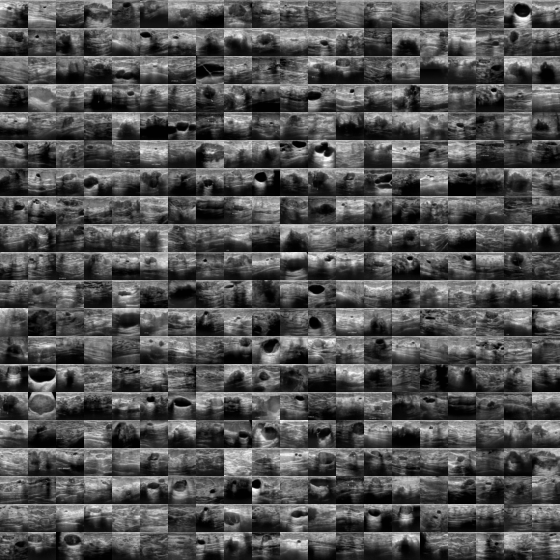

In [5]:
"""
This block shows the details of the datasets you generated above.
"""
print(train_dataset)
print("===================")
print(val_dataset)
print("===================")
print(test_dataset)
train_dataset.montage(length=20)

Please fill the blanks in the following block to show the image and its corresponding class label of 2 subjects:
1. the 50th subject in training dataset
2. the 20th subject in test dataset



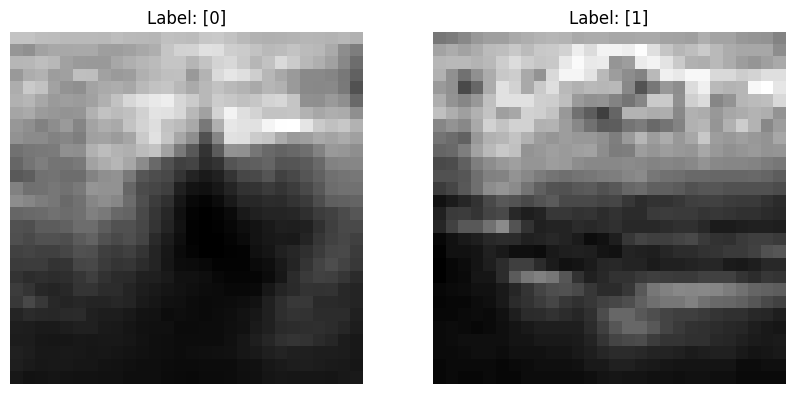

In [6]:
"""
Please query images and labels and visualize both images with labels as title.
"""
# query images and corresponding labels

im_1, label_1 = train_dataset[49]
im_2, label_2 = test_dataset[19]

# visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(im_1[0], cmap='gray')
ax2.imshow(im_2[0], cmap='gray')

ax1.set_title(f"Label: {label_1}")
ax1.axis('off')
ax2.set_title(f"Label: {label_2}")
ax2.axis('off')

plt.show()


## Upsampling and downsampling
Upsample the aforementioned subjects with bilinear algorithm from 28$\times$28 to 56$\times$56 and apply a 2D max pooling over the same subjects with kernel size equals 2 and stride equals 2.

**You are expected to use classes implememted in torch.nn.**
*Hit: Pay attention to the dimension of inputs.*


The size of resulted images: torch.Size([1, 28, 28]).


<Figure size 640x480 with 0 Axes>

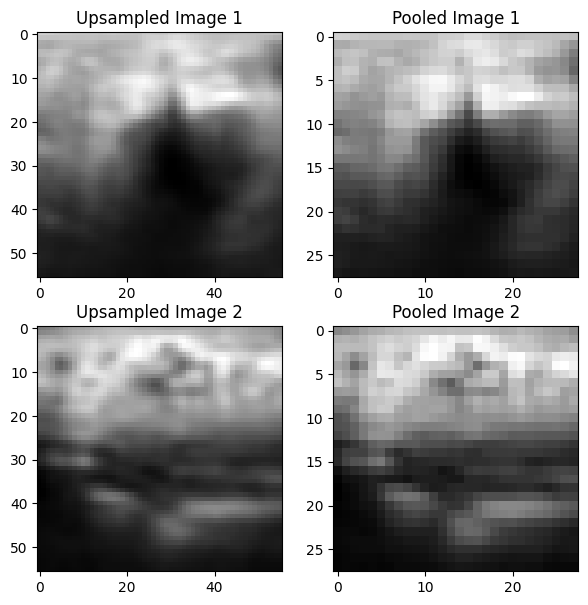

In [7]:
"""
Please realize upsampling and pooling of target images.
Visualize them with 2*2 subplots and print the size of images.

"""

# upsampling
upsample = nn.Upsample(size=(56,56), mode="bilinear")
upsampled_im_1 = upsample(im_1.unsqueeze(0))
upsampled_im_2 = upsample(im_2.unsqueeze(0))

# downsampling
pooled_im_1 = nn.MaxPool2d(2, 2)(upsampled_im_1)
pooled_im_2 = nn.MaxPool2d(2, 2)(upsampled_im_2)

# visualization
plt.figure()
f, axarr = plt.subplots(2, 2, figsize=(7, 7))
axarr[0, 0].imshow(upsampled_im_1[0][0], cmap='gray')
axarr[0, 1].imshow(pooled_im_1[0][0], cmap='gray')
axarr[1, 0].imshow(upsampled_im_2[0][0], cmap='gray')
axarr[1, 1].imshow(pooled_im_2[0][0], cmap='gray')

axarr[0, 0].set_title("Upsampled Image 1")
axarr[0, 1].set_title("Pooled Image 1")
axarr[1, 0].set_title("Upsampled Image 2")
axarr[1, 1].set_title("Pooled Image 2")

print(f'The size of resulted images: {im_1.shape}.')

## Model implementation

Here you should implement a basic CNN model with 5 convolutional layers. The output layer should be two linear layers. The output activation is sigmoid function.

Define a loss criterion that measures the Binary Cross Entropy between the target and the input probabilities with mean reduction.

In [8]:
"""
Please design a CNN model. You are execpted to invole batch normalization and pooling.
"""

# define the architecture of the model
class CNN(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(CNN, self).__init__()
        # 1 x 28 x 28
        self.conv_1 = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3, stride=1, padding=1), 
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        # 16 x 14 x 14
        self.conv_2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )
        # 32 x 7 x 7
        self.conv_3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=2, stride=1, padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        # 64 x 6 x 6
        self.conv_4 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=2, stride=1, padding=0),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        # 128 x 5 x 5
        self.conv_5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=2, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )
        # 256 x 3 x 3
        self.fc_1 = nn.Linear(256 * 3 * 3, 256)
        # # 1 x 512
        self.fc_2 = nn.Sequential(
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
        # # 1 x num_classes

    def forward(self, x):
        x = self.conv_1(x)
        x = self.conv_2(x)
        x = self.conv_3(x)
        x = self.conv_4(x)
        x = self.conv_5(x)
        x = x.view(x.size(0), -1)
        x = self.fc_1(x)
        x = self.fc_2(x)
        return x

# initialize your model
cnn_model = CNN(in_channels=n_channels, num_classes=n_classes)
cnn_model.to(device)
# define the BCE loss function and an optimizer you prefer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(cnn_model.parameters(), lr=lr, momentum=0.9)

Here shows the summary of designed CNN architecture.

In [9]:
"""
Here shows the summary of the model you designed with input size of your data and batch size you chose.
Please pass the size of data size to SAMPLE_DATASIZE.
"""
from torchsummary import summary
SAMPLE_DATASIZE = (1, 28, 28)
summary(cnn_model, SAMPLE_DATASIZE, BATCH_SIZE)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [128, 16, 28, 28]             160
       BatchNorm2d-2          [128, 16, 28, 28]              32
              ReLU-3          [128, 16, 28, 28]               0
         MaxPool2d-4          [128, 16, 14, 14]               0
            Conv2d-5          [128, 32, 14, 14]           4,640
       BatchNorm2d-6          [128, 32, 14, 14]              64
              ReLU-7          [128, 32, 14, 14]               0
         MaxPool2d-8            [128, 32, 7, 7]               0
            Conv2d-9            [128, 64, 6, 6]           8,256
      BatchNorm2d-10            [128, 64, 6, 6]             128
             ReLU-11            [128, 64, 6, 6]               0
           Conv2d-12           [128, 128, 5, 5]          32,896
      BatchNorm2d-13           [128, 128, 5, 5]             256
             ReLU-14           [128, 12

## Training and evaluation

Please fill the blanks in train and test functions.

In [10]:
"""
Please define functions for training and testing.
- train:
    input: dataloader, model
    output: loss_values for training and validation which is a list containing losses for all epochs.
            trained_model
- test:
    input: dataloader, model
    output: auc, acc
    Please also plot the test ROC curve for each class.
"""
# train and validation
def train(train_loader, model):
    loss_values = []
    val_loss_values = []

    for epoch in range(EPOCH_NUM):
        # Training
        model.train()        
        epoch_loss = 0
        step = 0
        for inputs, labels in tqdm(train_loader):
            step += 1
            inputs, labels = inputs.to(torch.float32).to(device), labels.to(torch.float32).to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        epoch_loss /= step
        print(f"Epoch training loss: {epoch_loss:.3f}")
        loss_values.append(epoch_loss)

        # Validate each epoch
        model.eval()
        val_epoch_loss = 0
        val_step = 0
        with torch.no_grad():
            for val_inputs, val_labels in tqdm(val_loader):
                val_step += 1
                val_inputs, val_labels = val_inputs.to(torch.float32).to(device), val_labels.to(torch.float32).to(device)
                val_outputs = model(val_inputs)
                val_loss = criterion(val_outputs, val_labels)
                val_epoch_loss += val_loss.item()
            val_epoch_loss /= val_step
            print(f"Epoch validation loss: {val_epoch_loss:.3f}")
            val_loss_values.append(val_epoch_loss)
                
    return loss_values, val_loss_values, model

# test
def test(test_loader, model):
    test_loss_values = []

    model.eval()
    test_outputs_list = []
    test_labels_list = []
    test_loss = 0
    test_step = 0
    with torch.no_grad():
        for test_inputs, test_labels in tqdm(test_loader):
            test_step += 1
            test_inputs, test_labels = test_inputs.to(torch.float32).to(device), test_labels.to(torch.float32).to(device)
            test_outputs = model(test_inputs)
            test_loss += criterion(test_outputs, test_labels)
            test_outputs_list.extend(test_outputs.cpu().numpy())
            test_labels_list.extend(test_labels.cpu().numpy())

        test_loss /= test_step
        test_loss_values.append(test_loss)
    
    auc = roc_auc_score(test_labels_list, test_outputs_list)
    acc = accuracy_score(test_labels_list, [1 if p >= 0.5 else 0 for p in test_outputs_list])
    
    return auc, acc

100%|██████████| 5/5 [00:03<00:00,  1.42it/s]


Epoch training loss: 0.613


100%|██████████| 1/1 [00:00<00:00,  5.76it/s]


Epoch validation loss: 0.607


100%|██████████| 5/5 [00:00<00:00,  6.16it/s]


Epoch training loss: 0.592


100%|██████████| 1/1 [00:00<00:00,  5.52it/s]


Epoch validation loss: 0.605


100%|██████████| 5/5 [00:00<00:00,  5.08it/s]


Epoch training loss: 0.594


100%|██████████| 1/1 [00:00<00:00,  7.16it/s]


Epoch validation loss: 0.602


100%|██████████| 5/5 [00:00<00:00,  5.57it/s]


Epoch training loss: 0.594


100%|██████████| 1/1 [00:00<00:00,  7.08it/s]


Epoch validation loss: 0.598


100%|██████████| 5/5 [00:00<00:00,  5.19it/s]


Epoch training loss: 0.574


100%|██████████| 1/1 [00:00<00:00,  5.12it/s]


Epoch validation loss: 0.593


100%|██████████| 5/5 [00:01<00:00,  3.92it/s]


Epoch training loss: 0.569


100%|██████████| 1/1 [00:00<00:00,  4.44it/s]


Epoch validation loss: 0.589


100%|██████████| 5/5 [00:00<00:00,  5.27it/s]


Epoch training loss: 0.576


100%|██████████| 1/1 [00:00<00:00, 10.96it/s]


Epoch validation loss: 0.584


100%|██████████| 5/5 [00:00<00:00,  5.44it/s]


Epoch training loss: 0.578


100%|██████████| 1/1 [00:00<00:00,  5.21it/s]

Epoch validation loss: 0.581



100%|██████████| 5/5 [00:01<00:00,  4.61it/s]


Epoch training loss: 0.551


100%|██████████| 1/1 [00:00<00:00,  4.96it/s]


Epoch validation loss: 0.578


100%|██████████| 5/5 [00:00<00:00,  5.22it/s]


Epoch training loss: 0.571


100%|██████████| 1/1 [00:00<00:00,  7.08it/s]


Epoch validation loss: 0.575


100%|██████████| 5/5 [00:00<00:00,  9.72it/s]


Epoch training loss: 0.573


100%|██████████| 1/1 [00:00<00:00, 11.15it/s]


Epoch validation loss: 0.572


100%|██████████| 5/5 [00:00<00:00,  9.85it/s]


Epoch training loss: 0.570


100%|██████████| 1/1 [00:00<00:00, 11.38it/s]


Epoch validation loss: 0.569


100%|██████████| 5/5 [00:00<00:00, 10.52it/s]


Epoch training loss: 0.570


100%|██████████| 1/1 [00:00<00:00, 12.03it/s]


Epoch validation loss: 0.566


100%|██████████| 5/5 [00:00<00:00, 10.59it/s]


Epoch training loss: 0.565


100%|██████████| 1/1 [00:00<00:00, 12.23it/s]


Epoch validation loss: 0.563


100%|██████████| 5/5 [00:00<00:00,  8.21it/s]


Epoch training loss: 0.545


100%|██████████| 1/1 [00:00<00:00,  7.06it/s]


Epoch validation loss: 0.561


100%|██████████| 5/5 [00:01<00:00,  4.15it/s]


Epoch training loss: 0.570


100%|██████████| 1/1 [00:00<00:00,  4.73it/s]


Epoch validation loss: 0.559


100%|██████████| 5/5 [00:00<00:00,  5.79it/s]


Epoch training loss: 0.553


100%|██████████| 1/1 [00:00<00:00,  8.01it/s]


Epoch validation loss: 0.556


100%|██████████| 5/5 [00:00<00:00,  8.92it/s]


Epoch training loss: 0.545


100%|██████████| 1/1 [00:00<00:00, 14.36it/s]


Epoch validation loss: 0.555


100%|██████████| 5/5 [00:00<00:00,  5.02it/s]


Epoch training loss: 0.543


100%|██████████| 1/1 [00:00<00:00, 10.06it/s]


Epoch validation loss: 0.553


100%|██████████| 5/5 [00:01<00:00,  4.23it/s]


Epoch training loss: 0.564


100%|██████████| 1/1 [00:00<00:00,  4.26it/s]


Epoch validation loss: 0.551


100%|██████████| 5/5 [00:01<00:00,  3.75it/s]


Epoch training loss: 0.549


100%|██████████| 1/1 [00:00<00:00,  5.37it/s]


Epoch validation loss: 0.550


100%|██████████| 5/5 [00:01<00:00,  3.89it/s]


Epoch training loss: 0.565


100%|██████████| 1/1 [00:00<00:00,  7.36it/s]


Epoch validation loss: 0.548


100%|██████████| 5/5 [00:01<00:00,  4.32it/s]


Epoch training loss: 0.539


100%|██████████| 1/1 [00:00<00:00,  6.20it/s]


Epoch validation loss: 0.546


100%|██████████| 5/5 [00:01<00:00,  3.46it/s]


Epoch training loss: 0.534


100%|██████████| 1/1 [00:00<00:00,  4.40it/s]


Epoch validation loss: 0.545


100%|██████████| 5/5 [00:01<00:00,  3.56it/s]


Epoch training loss: 0.547


100%|██████████| 1/1 [00:00<00:00,  5.38it/s]


Epoch validation loss: 0.543


100%|██████████| 5/5 [00:01<00:00,  3.44it/s]


Epoch training loss: 0.549


100%|██████████| 1/1 [00:00<00:00,  5.56it/s]


Epoch validation loss: 0.542


100%|██████████| 5/5 [00:01<00:00,  3.93it/s]


Epoch training loss: 0.536


100%|██████████| 1/1 [00:00<00:00,  6.77it/s]


Epoch validation loss: 0.541


100%|██████████| 5/5 [00:00<00:00,  9.09it/s]


Epoch training loss: 0.544


100%|██████████| 1/1 [00:00<00:00, 15.60it/s]


Epoch validation loss: 0.540


100%|██████████| 5/5 [00:00<00:00, 10.59it/s]


Epoch training loss: 0.551


100%|██████████| 1/1 [00:00<00:00, 13.77it/s]


Epoch validation loss: 0.539


100%|██████████| 5/5 [00:00<00:00,  5.40it/s]


Epoch training loss: 0.541


100%|██████████| 1/1 [00:00<00:00,  7.34it/s]


Epoch validation loss: 0.538


100%|██████████| 5/5 [00:00<00:00,  6.32it/s]


Epoch training loss: 0.539


100%|██████████| 1/1 [00:00<00:00,  7.97it/s]


Epoch validation loss: 0.537


100%|██████████| 5/5 [00:00<00:00,  6.88it/s]


Epoch training loss: 0.526


100%|██████████| 1/1 [00:00<00:00,  9.07it/s]


Epoch validation loss: 0.536


100%|██████████| 5/5 [00:00<00:00,  6.54it/s]


Epoch training loss: 0.531


100%|██████████| 1/1 [00:00<00:00,  6.80it/s]


Epoch validation loss: 0.535


100%|██████████| 5/5 [00:00<00:00, 10.16it/s]


Epoch training loss: 0.526


100%|██████████| 1/1 [00:00<00:00, 18.24it/s]


Epoch validation loss: 0.534


100%|██████████| 5/5 [00:00<00:00, 11.06it/s]


Epoch training loss: 0.539


100%|██████████| 1/1 [00:00<00:00,  8.91it/s]


Epoch validation loss: 0.533


100%|██████████| 5/5 [00:00<00:00,  8.15it/s]


Epoch training loss: 0.528


100%|██████████| 1/1 [00:00<00:00, 12.58it/s]


Epoch validation loss: 0.532


100%|██████████| 5/5 [00:00<00:00,  8.05it/s]


Epoch training loss: 0.536


100%|██████████| 1/1 [00:00<00:00,  6.29it/s]


Epoch validation loss: 0.531


100%|██████████| 5/5 [00:00<00:00,  6.55it/s]


Epoch training loss: 0.532


100%|██████████| 1/1 [00:00<00:00,  7.54it/s]


Epoch validation loss: 0.530


100%|██████████| 5/5 [00:00<00:00,  6.58it/s]


Epoch training loss: 0.531


100%|██████████| 1/1 [00:00<00:00,  5.73it/s]


Epoch validation loss: 0.529


100%|██████████| 5/5 [00:00<00:00,  5.34it/s]


Epoch training loss: 0.529


100%|██████████| 1/1 [00:00<00:00, 18.45it/s]


Epoch validation loss: 0.529


100%|██████████| 5/5 [00:00<00:00,  6.06it/s]


Epoch training loss: 0.525


100%|██████████| 1/1 [00:00<00:00,  7.40it/s]


Epoch validation loss: 0.528


100%|██████████| 5/5 [00:01<00:00,  4.86it/s]


Epoch training loss: 0.529


100%|██████████| 1/1 [00:00<00:00,  4.43it/s]


Epoch validation loss: 0.527


100%|██████████| 5/5 [00:00<00:00,  6.37it/s]


Epoch training loss: 0.533


100%|██████████| 1/1 [00:00<00:00, 11.28it/s]


Epoch validation loss: 0.526


100%|██████████| 5/5 [00:00<00:00,  7.24it/s]


Epoch training loss: 0.518


100%|██████████| 1/1 [00:00<00:00,  5.15it/s]


Epoch validation loss: 0.525


100%|██████████| 5/5 [00:00<00:00,  7.20it/s]


Epoch training loss: 0.531


100%|██████████| 1/1 [00:00<00:00,  7.69it/s]


Epoch validation loss: 0.524


100%|██████████| 5/5 [00:00<00:00,  7.81it/s]


Epoch training loss: 0.523


100%|██████████| 1/1 [00:00<00:00, 11.60it/s]


Epoch validation loss: 0.524


100%|██████████| 5/5 [00:00<00:00,  7.33it/s]


Epoch training loss: 0.527


100%|██████████| 1/1 [00:00<00:00,  8.31it/s]


Epoch validation loss: 0.523


100%|██████████| 5/5 [00:00<00:00,  7.20it/s]


Epoch training loss: 0.534


100%|██████████| 1/1 [00:00<00:00,  8.12it/s]


Epoch validation loss: 0.523


100%|██████████| 5/5 [00:00<00:00,  8.86it/s]


Epoch training loss: 0.510


100%|██████████| 1/1 [00:00<00:00, 10.06it/s]


Epoch validation loss: 0.522


100%|██████████| 5/5 [00:01<00:00,  4.00it/s]


Epoch training loss: 0.527


100%|██████████| 1/1 [00:00<00:00,  3.92it/s]


Epoch validation loss: 0.520


100%|██████████| 5/5 [00:01<00:00,  3.28it/s]


Epoch training loss: 0.518


100%|██████████| 1/1 [00:00<00:00,  4.38it/s]


Epoch validation loss: 0.520


100%|██████████| 5/5 [00:00<00:00,  6.09it/s]


Epoch training loss: 0.506


100%|██████████| 1/1 [00:00<00:00,  8.49it/s]


Epoch validation loss: 0.519


100%|██████████| 5/5 [00:00<00:00,  7.21it/s]


Epoch training loss: 0.526


100%|██████████| 1/1 [00:00<00:00, 10.30it/s]


Epoch validation loss: 0.518


100%|██████████| 5/5 [00:00<00:00,  5.31it/s]


Epoch training loss: 0.510


100%|██████████| 1/1 [00:00<00:00,  3.94it/s]


Epoch validation loss: 0.518


100%|██████████| 5/5 [00:01<00:00,  3.91it/s]


Epoch training loss: 0.534


100%|██████████| 1/1 [00:00<00:00,  4.13it/s]


Epoch validation loss: 0.517


100%|██████████| 5/5 [00:01<00:00,  4.04it/s]


Epoch training loss: 0.513


100%|██████████| 1/1 [00:00<00:00,  4.76it/s]


Epoch validation loss: 0.517


100%|██████████| 5/5 [00:01<00:00,  3.69it/s]


Epoch training loss: 0.509


100%|██████████| 1/1 [00:00<00:00,  4.93it/s]


Epoch validation loss: 0.516


100%|██████████| 5/5 [00:01<00:00,  4.12it/s]


Epoch training loss: 0.506


100%|██████████| 1/1 [00:00<00:00,  8.03it/s]


Epoch validation loss: 0.515


100%|██████████| 5/5 [00:00<00:00,  5.16it/s]


Epoch training loss: 0.513


100%|██████████| 1/1 [00:00<00:00,  6.33it/s]


Epoch validation loss: 0.515


100%|██████████| 5/5 [00:00<00:00,  5.33it/s]


Epoch training loss: 0.513


100%|██████████| 1/1 [00:00<00:00,  4.61it/s]


Epoch validation loss: 0.514


100%|██████████| 5/5 [00:00<00:00,  5.15it/s]


Epoch training loss: 0.508


100%|██████████| 1/1 [00:00<00:00,  5.18it/s]


Epoch validation loss: 0.513


100%|██████████| 5/5 [00:00<00:00,  5.63it/s]


Epoch training loss: 0.514


100%|██████████| 1/1 [00:00<00:00,  6.25it/s]


Epoch validation loss: 0.512


100%|██████████| 5/5 [00:01<00:00,  4.86it/s]


Epoch training loss: 0.514


100%|██████████| 1/1 [00:00<00:00,  5.11it/s]


Epoch validation loss: 0.512


100%|██████████| 5/5 [00:01<00:00,  4.26it/s]


Epoch training loss: 0.516


100%|██████████| 1/1 [00:00<00:00,  5.58it/s]


Epoch validation loss: 0.512


100%|██████████| 5/5 [00:01<00:00,  4.54it/s]


Epoch training loss: 0.503


100%|██████████| 1/1 [00:00<00:00,  6.23it/s]


Epoch validation loss: 0.511


100%|██████████| 5/5 [00:00<00:00,  5.17it/s]


Epoch training loss: 0.510


100%|██████████| 1/1 [00:00<00:00,  7.30it/s]


Epoch validation loss: 0.510


100%|██████████| 5/5 [00:00<00:00,  7.24it/s]


Epoch training loss: 0.495


100%|██████████| 1/1 [00:00<00:00,  5.38it/s]


Epoch validation loss: 0.510


100%|██████████| 5/5 [00:01<00:00,  4.57it/s]


Epoch training loss: 0.514


100%|██████████| 1/1 [00:00<00:00,  5.36it/s]


Epoch validation loss: 0.509


100%|██████████| 5/5 [00:00<00:00,  5.51it/s]


Epoch training loss: 0.512


100%|██████████| 1/1 [00:00<00:00,  8.37it/s]


Epoch validation loss: 0.508


100%|██████████| 5/5 [00:00<00:00,  6.92it/s]


Epoch training loss: 0.498


100%|██████████| 1/1 [00:00<00:00, 11.00it/s]


Epoch validation loss: 0.509


100%|██████████| 5/5 [00:00<00:00,  8.11it/s]


Epoch training loss: 0.510


100%|██████████| 1/1 [00:00<00:00, 10.32it/s]


Epoch validation loss: 0.508


100%|██████████| 5/5 [00:00<00:00,  7.64it/s]


Epoch training loss: 0.513


100%|██████████| 1/1 [00:00<00:00, 13.98it/s]


Epoch validation loss: 0.507


100%|██████████| 5/5 [00:00<00:00,  6.40it/s]


Epoch training loss: 0.504


100%|██████████| 1/1 [00:00<00:00,  8.69it/s]


Epoch validation loss: 0.507


100%|██████████| 5/5 [00:00<00:00,  6.10it/s]


Epoch training loss: 0.515


100%|██████████| 1/1 [00:00<00:00,  9.71it/s]


Epoch validation loss: 0.506


100%|██████████| 5/5 [00:00<00:00,  7.43it/s]


Epoch training loss: 0.530


100%|██████████| 1/1 [00:00<00:00,  9.51it/s]


Epoch validation loss: 0.505


100%|██████████| 5/5 [00:00<00:00,  6.21it/s]


Epoch training loss: 0.494


100%|██████████| 1/1 [00:00<00:00,  6.99it/s]


Epoch validation loss: 0.505


100%|██████████| 5/5 [00:00<00:00,  6.46it/s]


Epoch training loss: 0.495


100%|██████████| 1/1 [00:00<00:00,  8.68it/s]


Epoch validation loss: 0.504


100%|██████████| 5/5 [00:00<00:00,  6.10it/s]


Epoch training loss: 0.498


100%|██████████| 1/1 [00:00<00:00,  8.40it/s]


Epoch validation loss: 0.503


100%|██████████| 5/5 [00:00<00:00,  7.32it/s]


Epoch training loss: 0.492


100%|██████████| 1/1 [00:00<00:00, 14.44it/s]


Epoch validation loss: 0.502


100%|██████████| 5/5 [00:00<00:00,  7.47it/s]


Epoch training loss: 0.487


100%|██████████| 1/1 [00:00<00:00,  9.08it/s]


Epoch validation loss: 0.502


100%|██████████| 5/5 [00:00<00:00,  8.99it/s]


Epoch training loss: 0.503


100%|██████████| 1/1 [00:00<00:00, 12.18it/s]


Epoch validation loss: 0.502


100%|██████████| 5/5 [00:00<00:00,  5.96it/s]


Epoch training loss: 0.489


100%|██████████| 1/1 [00:00<00:00, 12.37it/s]


Epoch validation loss: 0.502


100%|██████████| 5/5 [00:00<00:00,  6.71it/s]


Epoch training loss: 0.495


100%|██████████| 1/1 [00:00<00:00, 11.88it/s]


Epoch validation loss: 0.502


100%|██████████| 5/5 [00:00<00:00,  6.88it/s]


Epoch training loss: 0.506


100%|██████████| 1/1 [00:00<00:00, 20.38it/s]


Epoch validation loss: 0.501


100%|██████████| 5/5 [00:00<00:00,  7.71it/s]


Epoch training loss: 0.493


100%|██████████| 1/1 [00:00<00:00, 14.60it/s]


Epoch validation loss: 0.500


100%|██████████| 5/5 [00:00<00:00,  5.80it/s]


Epoch training loss: 0.493


100%|██████████| 1/1 [00:00<00:00,  8.58it/s]


Epoch validation loss: 0.499


100%|██████████| 5/5 [00:00<00:00,  9.14it/s]


Epoch training loss: 0.506


100%|██████████| 1/1 [00:00<00:00,  7.40it/s]


Epoch validation loss: 0.500


100%|██████████| 5/5 [00:01<00:00,  4.35it/s]


Epoch training loss: 0.487


100%|██████████| 1/1 [00:00<00:00,  8.91it/s]


Epoch validation loss: 0.499


100%|██████████| 5/5 [00:00<00:00,  7.18it/s]


Epoch training loss: 0.486


100%|██████████| 1/1 [00:00<00:00,  7.06it/s]


Epoch validation loss: 0.498


100%|██████████| 5/5 [00:01<00:00,  3.39it/s]


Epoch training loss: 0.493


100%|██████████| 1/1 [00:00<00:00,  3.73it/s]


Epoch validation loss: 0.497


100%|██████████| 5/5 [00:00<00:00,  5.92it/s]


Epoch training loss: 0.499


100%|██████████| 1/1 [00:00<00:00,  9.27it/s]


Epoch validation loss: 0.497


100%|██████████| 5/5 [00:00<00:00,  6.59it/s]


Epoch training loss: 0.494


100%|██████████| 1/1 [00:00<00:00, 13.70it/s]


Epoch validation loss: 0.497


100%|██████████| 5/5 [00:00<00:00,  6.78it/s]


Epoch training loss: 0.485


100%|██████████| 1/1 [00:00<00:00, 12.92it/s]


Epoch validation loss: 0.496


100%|██████████| 5/5 [00:00<00:00,  7.38it/s]


Epoch training loss: 0.498


100%|██████████| 1/1 [00:00<00:00, 12.22it/s]


Epoch validation loss: 0.496


100%|██████████| 5/5 [00:00<00:00,  9.86it/s]


Epoch training loss: 0.477


100%|██████████| 1/1 [00:00<00:00, 12.98it/s]


Epoch validation loss: 0.495


100%|██████████| 5/5 [00:00<00:00,  8.13it/s]


Epoch training loss: 0.499


100%|██████████| 1/1 [00:00<00:00, 13.74it/s]


Epoch validation loss: 0.495


100%|██████████| 5/5 [00:00<00:00,  9.93it/s]


Epoch training loss: 0.503


100%|██████████| 1/1 [00:00<00:00, 16.61it/s]


Epoch validation loss: 0.495


100%|██████████| 5/5 [00:00<00:00, 10.03it/s]


Epoch training loss: 0.481


100%|██████████| 1/1 [00:00<00:00, 16.34it/s]


Epoch validation loss: 0.494


100%|██████████| 5/5 [00:00<00:00,  9.88it/s]


Epoch training loss: 0.496


100%|██████████| 1/1 [00:00<00:00, 14.24it/s]


Epoch validation loss: 0.494


100%|██████████| 5/5 [00:00<00:00,  7.76it/s]


Epoch training loss: 0.481


100%|██████████| 1/1 [00:00<00:00, 11.58it/s]


Epoch validation loss: 0.494


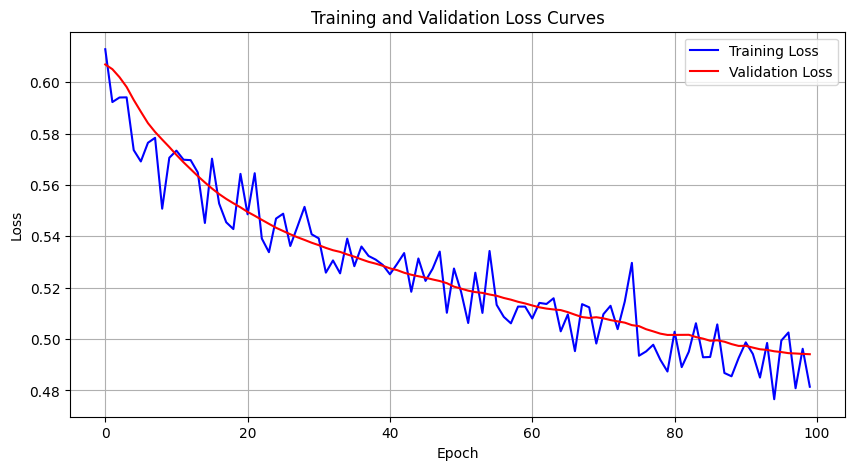

100%|██████████| 1/1 [00:00<00:00,  5.15it/s]


auc: 0.863, acc: 0.840


In [11]:
"""
Here shows the training and validation curves. AUC and ACC of test will also be printed.
"""
# train
loss_values, val_loss_values, model = train(train_loader=train_loader, model=cnn_model)

# show training and validation curves
plt.figure(figsize=(10, 5))
plt.plot(loss_values, label='Training Loss', color='blue')
plt.plot(val_loss_values, label='Validation Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.grid(True)
plt.show()

# test
auc, acc = test(test_loader=test_loader, model=cnn_model)
print(f'auc: {auc:.3f}, acc: {acc:.3f}') # round both to the first 3 digits

# 3D dataset NoduleMNIST3D

Please fill the blanks in the following block to create dataloaders for training, validation, and test on 3D dataset. The visualization of each dataset is expected.

{'python_class': 'NoduleMNIST3D', 'description': 'The NoduleMNIST3D is based on the LIDC-IDRI, a large public lung nodule dataset, containing images from thoracic CT scans. The dataset is designed for both lung nodule segmentation and 5-level malignancy classification task. To perform binary classification, we categorize cases with malignancy level 1/2 into negative class and 4/5 into positive class, ignoring the cases with malignancy level 3. We split the source dataset with a ratio of 7:1:2 into training, validation and test set, and center-crop the spatially normalized images (with a spacing of 1mm×1mm×1mm) into 28×28×28.', 'url': 'https://zenodo.org/record/6496656/files/nodulemnist3d.npz?download=1', 'MD5': '8755a7e9e05a4d9ce80a24c3e7a256f3', 'task': 'binary-class', 'label': {'0': 'benign', '1': 'malignant'}, 'n_channels': 1, 'n_samples': {'train': 1158, 'val': 165, 'test': 310}, 'license': 'CC BY 4.0'}
Using downloaded and verified file: /home/viet/.medmnist/nodulemnist3d.npz


Using downloaded and verified file: /home/viet/.medmnist/nodulemnist3d.npz
Using downloaded and verified file: /home/viet/.medmnist/nodulemnist3d.npz
Dataset NoduleMNIST3D (nodulemnist3d)
    Number of datapoints: 1158
    Root location: /home/viet/.medmnist
    Split: train
    Task: binary-class
    Number of channels: 1
    Meaning of labels: {'0': 'benign', '1': 'malignant'}
    Number of samples: {'train': 1158, 'val': 165, 'test': 310}
    Description: The NoduleMNIST3D is based on the LIDC-IDRI, a large public lung nodule dataset, containing images from thoracic CT scans. The dataset is designed for both lung nodule segmentation and 5-level malignancy classification task. To perform binary classification, we categorize cases with malignancy level 1/2 into negative class and 4/5 into positive class, ignoring the cases with malignancy level 3. We split the source dataset with a ratio of 7:1:2 into training, validation and test set, and center-crop the spatially normalized images (

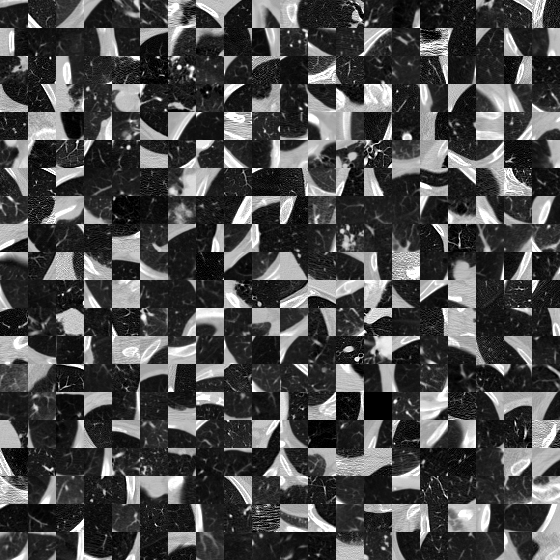

In [13]:
# hyparameters
BATCH_SIZE = 32
EPOCH_NUM = 50
lr = 0.001

# dataset
data_flag_3d = 'nodulemnist3d' # here the name of dataset should be passed.
download = True

info = INFO[data_flag_3d] # INFO is embedded in the medmnist containing basic information of datasets
print(info)
task = info['task']

n_channels = info['n_channels']
n_classes = len(info['label'])

# get the data class without transform
DataClass = getattr(medmnist, info['python_class'])
train_dataset = DataClass(split="train", download=download)
test_dataset = DataClass(split="test", download=download)
val_dataset = DataClass(split="val", download=download)

# encapsulate datasets into Dataloader form
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
val_loader = DataLoader(dataset=val_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

# show the details
print(train_dataset)
print("===================")
print(val_dataset)
print("===================")
print(test_dataset)
train_dataset.montage(length=20)[0]

## 3D CNN implementation

Similar to what you have completed, please fill the blanks in following methods.

You expected to design a 3D CNN with 5 layers along with batch normalization and pooling.

In [14]:
class CNN_3D(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(CNN_3D, self).__init__()
        # 1 x 28 x 28 x 28
        self.conv_1 = nn.Sequential(
            nn.Conv3d(in_channels, 16, kernel_size=3, stride=1, padding=1), 
            nn.BatchNorm3d(16),
            nn.ReLU(),
            nn.MaxPool3d(2, 2)
        )
        # 16 x 14 x 14 x 14
        self.conv_2 = nn.Sequential(
            nn.Conv3d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm3d(32),
            nn.ReLU(),
            nn.MaxPool3d(2,2)
        )
        # 32 x 7 x 7 x 7
        self.conv_3 = nn.Sequential(
            nn.Conv3d(32, 64, kernel_size=2, stride=1, padding=0),
            nn.BatchNorm3d(64),
            nn.ReLU()
        )
        # 64 x 6 x 6 x 6
        self.conv_4 = nn.Sequential(
            nn.Conv3d(64, 128, kernel_size=2, stride=1, padding=0),
            nn.BatchNorm3d(128),
            nn.ReLU()
        )
        # 128 x 5 x 5 x 5
        self.conv_5 = nn.Sequential(
            nn.Conv3d(128, 256, kernel_size=2, stride=1, padding=1),
            nn.BatchNorm3d(256),
            nn.ReLU(),
            nn.MaxPool3d(2,2)
        )
        # 256 x 3 x 3 x 3
        self.fc_1 = nn.Linear(256 * 3 * 3 * 3, 2048)
        # # 1 x 512
        self.fc_2 = nn.Sequential(
            nn.Linear(2048, 1),
        )
        # # 1 x num_classes

    def forward(self, x):
        x = self.conv_1(x)
        x = self.conv_2(x)
        x = self.conv_3(x)
        x = self.conv_4(x)
        x = self.conv_5(x)
        x = x.view(x.size(0), -1)
        x = self.fc_1(x)
        x = self.fc_2(x)
        return x

# initialize the 3D model
cnn3d_model = CNN_3D(in_channels=n_channels, num_classes=n_classes)
cnn3d_model.to(device)
# define the BCE loss function and an optimizer you prefer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(cnn3d_model.parameters(), lr=lr, momentum=0.9)

# show the details
from torchsummary import summary
SAMPLE_DATASIZE = (1, 28, 28, 28) # please pass the size of data size to SAMPLE_DATASIZE
summary(cnn3d_model, SAMPLE_DATASIZE, BATCH_SIZE)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1       [32, 16, 28, 28, 28]             448
       BatchNorm3d-2       [32, 16, 28, 28, 28]              32
              ReLU-3       [32, 16, 28, 28, 28]               0
         MaxPool3d-4       [32, 16, 14, 14, 14]               0
            Conv3d-5       [32, 32, 14, 14, 14]          13,856
       BatchNorm3d-6       [32, 32, 14, 14, 14]              64
              ReLU-7       [32, 32, 14, 14, 14]               0
         MaxPool3d-8          [32, 32, 7, 7, 7]               0
            Conv3d-9          [32, 64, 6, 6, 6]          16,448
      BatchNorm3d-10          [32, 64, 6, 6, 6]             128
             ReLU-11          [32, 64, 6, 6, 6]               0
           Conv3d-12         [32, 128, 5, 5, 5]          65,664
      BatchNorm3d-13         [32, 128, 5, 5, 5]             256
             ReLU-14         [32, 128, 

## Training and evaluation

Please fill empty blanks in the following block and modify the train and test functions if it is necessary. Note that train and test functions should work for both 2D CNN and 3D CNN.

100%|██████████| 37/37 [00:06<00:00,  6.04it/s]


Epoch training loss: 0.505


100%|██████████| 3/3 [00:00<00:00,  7.69it/s]


Epoch validation loss: 0.417


100%|██████████| 37/37 [00:06<00:00,  5.85it/s]


Epoch training loss: 0.350


100%|██████████| 3/3 [00:00<00:00,  5.08it/s]


Epoch validation loss: 0.400


100%|██████████| 37/37 [00:06<00:00,  5.70it/s]


Epoch training loss: 0.305


100%|██████████| 3/3 [00:00<00:00,  8.26it/s]


Epoch validation loss: 0.390


100%|██████████| 37/37 [00:07<00:00,  4.91it/s]


Epoch training loss: 0.250


100%|██████████| 3/3 [00:00<00:00,  3.27it/s]


Epoch validation loss: 0.380


100%|██████████| 37/37 [00:07<00:00,  4.91it/s]


Epoch training loss: 0.210


100%|██████████| 3/3 [00:00<00:00,  8.17it/s]


Epoch validation loss: 0.414


100%|██████████| 37/37 [00:05<00:00,  6.50it/s]


Epoch training loss: 0.186


100%|██████████| 3/3 [00:00<00:00,  9.40it/s]


Epoch validation loss: 0.366


100%|██████████| 37/37 [00:05<00:00,  6.60it/s]


Epoch training loss: 0.124


100%|██████████| 3/3 [00:00<00:00,  9.89it/s]


Epoch validation loss: 0.389


100%|██████████| 37/37 [00:05<00:00,  6.59it/s]


Epoch training loss: 0.109


100%|██████████| 3/3 [00:00<00:00, 10.22it/s]


Epoch validation loss: 0.584


100%|██████████| 37/37 [00:05<00:00,  6.61it/s]


Epoch training loss: 0.098


100%|██████████| 3/3 [00:00<00:00,  8.51it/s]


Epoch validation loss: 0.391


100%|██████████| 37/37 [00:05<00:00,  6.29it/s]


Epoch training loss: 0.052


100%|██████████| 3/3 [00:00<00:00,  7.70it/s]


Epoch validation loss: 0.395


100%|██████████| 37/37 [00:05<00:00,  6.46it/s]


Epoch training loss: 0.038


100%|██████████| 3/3 [00:00<00:00,  8.15it/s]


Epoch validation loss: 0.403


100%|██████████| 37/37 [00:06<00:00,  5.86it/s]


Epoch training loss: 0.030


100%|██████████| 3/3 [00:00<00:00,  9.51it/s]


Epoch validation loss: 0.422


100%|██████████| 37/37 [00:06<00:00,  6.02it/s]


Epoch training loss: 0.018


100%|██████████| 3/3 [00:00<00:00,  8.61it/s]


Epoch validation loss: 0.434


100%|██████████| 37/37 [00:05<00:00,  6.26it/s]


Epoch training loss: 0.015


100%|██████████| 3/3 [00:00<00:00,  8.85it/s]


Epoch validation loss: 0.465


100%|██████████| 37/37 [00:05<00:00,  6.45it/s]


Epoch training loss: 0.014


100%|██████████| 3/3 [00:00<00:00,  8.88it/s]


Epoch validation loss: 0.487


100%|██████████| 37/37 [00:05<00:00,  6.22it/s]


Epoch training loss: 0.010


100%|██████████| 3/3 [00:00<00:00,  8.25it/s]


Epoch validation loss: 0.472


100%|██████████| 37/37 [00:05<00:00,  6.18it/s]


Epoch training loss: 0.007


100%|██████████| 3/3 [00:00<00:00,  8.10it/s]


Epoch validation loss: 0.493


100%|██████████| 37/37 [00:06<00:00,  6.08it/s]


Epoch training loss: 0.009


100%|██████████| 3/3 [00:00<00:00,  8.82it/s]


Epoch validation loss: 0.489


100%|██████████| 37/37 [00:06<00:00,  5.77it/s]


Epoch training loss: 0.009


100%|██████████| 3/3 [00:00<00:00, 10.11it/s]


Epoch validation loss: 0.492


100%|██████████| 37/37 [00:05<00:00,  6.17it/s]


Epoch training loss: 0.006


100%|██████████| 3/3 [00:00<00:00,  9.45it/s]


Epoch validation loss: 0.501


100%|██████████| 37/37 [00:05<00:00,  6.25it/s]


Epoch training loss: 0.005


100%|██████████| 3/3 [00:00<00:00, 10.24it/s]


Epoch validation loss: 0.507


100%|██████████| 37/37 [00:05<00:00,  6.51it/s]


Epoch training loss: 0.004


100%|██████████| 3/3 [00:00<00:00, 10.14it/s]


Epoch validation loss: 0.532


100%|██████████| 37/37 [00:05<00:00,  6.28it/s]


Epoch training loss: 0.004


100%|██████████| 3/3 [00:00<00:00,  9.55it/s]


Epoch validation loss: 0.519


100%|██████████| 37/37 [00:05<00:00,  6.22it/s]


Epoch training loss: 0.004


100%|██████████| 3/3 [00:00<00:00, 10.08it/s]


Epoch validation loss: 0.516


100%|██████████| 37/37 [00:05<00:00,  6.31it/s]


Epoch training loss: 0.004


100%|██████████| 3/3 [00:00<00:00,  9.42it/s]


Epoch validation loss: 0.506


100%|██████████| 37/37 [00:05<00:00,  6.22it/s]


Epoch training loss: 0.003


100%|██████████| 3/3 [00:00<00:00,  9.91it/s]


Epoch validation loss: 0.539


100%|██████████| 37/37 [00:05<00:00,  6.19it/s]


Epoch training loss: 0.003


100%|██████████| 3/3 [00:00<00:00, 10.07it/s]


Epoch validation loss: 0.537


100%|██████████| 37/37 [00:06<00:00,  5.76it/s]


Epoch training loss: 0.003


100%|██████████| 3/3 [00:00<00:00,  8.55it/s]


Epoch validation loss: 0.536


100%|██████████| 37/37 [00:06<00:00,  5.92it/s]


Epoch training loss: 0.002


100%|██████████| 3/3 [00:00<00:00,  7.86it/s]


Epoch validation loss: 0.551


100%|██████████| 37/37 [00:07<00:00,  5.21it/s]


Epoch training loss: 0.002


100%|██████████| 3/3 [00:00<00:00,  8.86it/s]


Epoch validation loss: 0.545


100%|██████████| 37/37 [00:05<00:00,  6.20it/s]


Epoch training loss: 0.002


100%|██████████| 3/3 [00:00<00:00,  9.40it/s]


Epoch validation loss: 0.550


100%|██████████| 37/37 [00:07<00:00,  5.09it/s]


Epoch training loss: 0.002


100%|██████████| 3/3 [00:00<00:00,  7.54it/s]


Epoch validation loss: 0.565


100%|██████████| 37/37 [00:07<00:00,  4.77it/s]


Epoch training loss: 0.002


100%|██████████| 3/3 [00:00<00:00,  7.42it/s]


Epoch validation loss: 0.551


100%|██████████| 37/37 [00:06<00:00,  5.86it/s]


Epoch training loss: 0.002


100%|██████████| 3/3 [00:00<00:00,  7.71it/s]


Epoch validation loss: 0.553


100%|██████████| 37/37 [00:06<00:00,  5.82it/s]


Epoch training loss: 0.003


100%|██████████| 3/3 [00:00<00:00,  7.50it/s]


Epoch validation loss: 0.563


100%|██████████| 37/37 [00:06<00:00,  5.89it/s]


Epoch training loss: 0.004


100%|██████████| 3/3 [00:00<00:00,  8.20it/s]


Epoch validation loss: 0.562


100%|██████████| 37/37 [00:06<00:00,  6.04it/s]


Epoch training loss: 0.002


100%|██████████| 3/3 [00:00<00:00,  9.16it/s]


Epoch validation loss: 0.586


100%|██████████| 37/37 [00:06<00:00,  5.95it/s]


Epoch training loss: 0.002


100%|██████████| 3/3 [00:00<00:00,  8.24it/s]


Epoch validation loss: 0.586


100%|██████████| 37/37 [00:06<00:00,  5.82it/s]


Epoch training loss: 0.002


100%|██████████| 3/3 [00:00<00:00,  8.16it/s]


Epoch validation loss: 0.576


100%|██████████| 37/37 [00:06<00:00,  5.89it/s]


Epoch training loss: 0.002


100%|██████████| 3/3 [00:00<00:00,  9.11it/s]


Epoch validation loss: 0.596


100%|██████████| 37/37 [00:06<00:00,  5.86it/s]


Epoch training loss: 0.002


100%|██████████| 3/3 [00:00<00:00,  7.60it/s]


Epoch validation loss: 0.587


100%|██████████| 37/37 [00:06<00:00,  5.91it/s]


Epoch training loss: 0.001


100%|██████████| 3/3 [00:00<00:00,  8.38it/s]


Epoch validation loss: 0.587


100%|██████████| 37/37 [00:06<00:00,  6.06it/s]


Epoch training loss: 0.003


100%|██████████| 3/3 [00:00<00:00,  9.36it/s]


Epoch validation loss: 0.575


100%|██████████| 37/37 [00:07<00:00,  5.05it/s]


Epoch training loss: 0.003


100%|██████████| 3/3 [00:00<00:00,  7.03it/s]


Epoch validation loss: 0.583


100%|██████████| 37/37 [00:07<00:00,  4.83it/s]


Epoch training loss: 0.002


100%|██████████| 3/3 [00:00<00:00,  7.62it/s]


Epoch validation loss: 0.587


100%|██████████| 37/37 [00:06<00:00,  5.30it/s]


Epoch training loss: 0.001


100%|██████████| 3/3 [00:00<00:00,  7.44it/s]


Epoch validation loss: 0.577


100%|██████████| 37/37 [00:07<00:00,  5.15it/s]


Epoch training loss: 0.001


100%|██████████| 3/3 [00:00<00:00,  4.96it/s]


Epoch validation loss: 0.593


100%|██████████| 37/37 [00:07<00:00,  5.05it/s]


Epoch training loss: 0.001


100%|██████████| 3/3 [00:00<00:00,  7.67it/s]


Epoch validation loss: 0.576


100%|██████████| 37/37 [00:06<00:00,  5.34it/s]


Epoch training loss: 0.001


100%|██████████| 3/3 [00:00<00:00,  8.89it/s]


Epoch validation loss: 0.586


100%|██████████| 37/37 [00:06<00:00,  5.44it/s]


Epoch training loss: 0.001


100%|██████████| 3/3 [00:00<00:00,  7.39it/s]


Epoch validation loss: 0.592


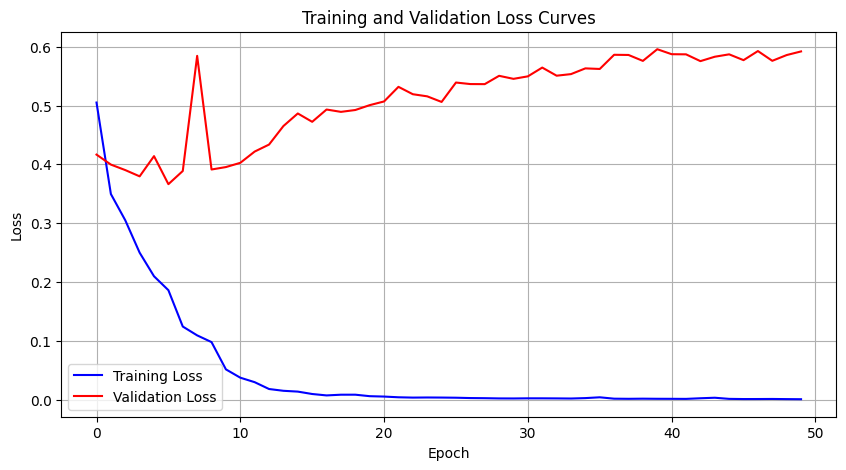

100%|██████████| 5/5 [00:01<00:00,  4.80it/s]

auc: 0.914, acc: 0.868


In [15]:
"""
Here shows the training and validation curves. AUC and ACC of test will also be printed.
"""
# train
loss_values, val_loss_values, model = train(train_loader=train_loader, model=cnn3d_model)

# show training and validation curves
plt.figure(figsize=(10, 5))
plt.plot(loss_values, label='Training Loss', color='blue')
plt.plot(val_loss_values, label='Validation Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.grid(True)
plt.show()

# test
auc, acc = test(test_loader=test_loader, model=cnn3d_model)
print(f'auc: {auc:.3f}, acc: {acc:.3f}') # round both to the first 3 digits

# What are the strengths and weaknesses of classification models?
### In the previous tasks, you worked on CNN and 3D CNN. What are other networks that can realize image classification? (Please make at least 3 examples.) Could you discuss the pros and cons of CNNs and the networks you listed in medical image classification?

Please write your solution here.